# Linear regression based rating prediction 

Project title: Automating literature reviews using recommender systems


Authors : Alarmelu PM, Akhila Bolisetty, Andrew Szeto

Typically linear regression model is not used in recommender systems but we can use it to understand the
correlation between the features and how it impacts the ratings colum

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats


In [2]:
df_in = pd.read_csv('sciencepapers_with_userprofiles.csv')
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              2294 non-null   int64  
 1   Area of interest  2294 non-null   object 
 2   Input             2294 non-null   object 
 3   title             2294 non-null   object 
 4   rating            2286 non-null   float64
 5   arxiv_id          2294 non-null   object 
 6   paperId           2294 non-null   object 
 7   created           2294 non-null   object 
 8   categories        2292 non-null   object 
 9   authors           2294 non-null   object 
 10  keywords          2294 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 197.3+ KB


In [4]:
df_in.loc[df_in.rating > 5, 'rating'] = np.nan
df_in.rating = df_in.rating.fillna(3).astype(int)
df_in.paperId = df_in.paperId.astype(int)

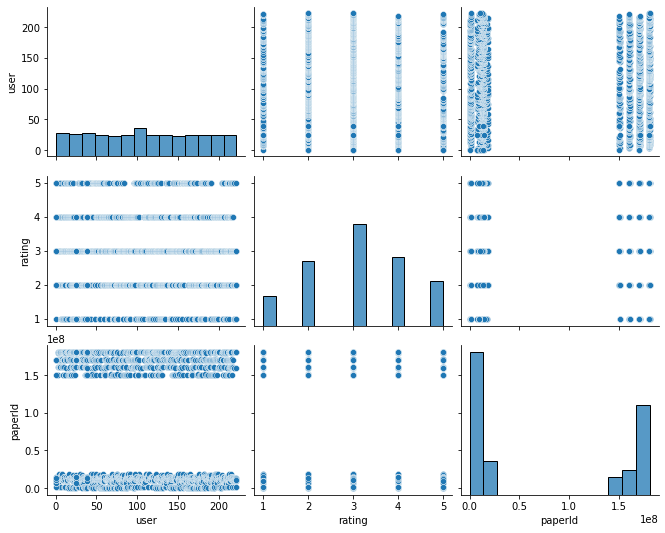

In [8]:
#general visual analysis of the relationships
sns.pairplot(df_in, height=2.5, aspect=1.25)

# Analyzing the Authors feature

Our target is to predict the ratings.
The X variable here in this simple linear regression would be the authors

In [41]:
# getting variables for authors
authors_df = pd.get_dummies(df_in['authors'])

In [42]:
X = authors_df
y = df_in.rating

In [44]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.7093


# Analyzing the categories feature

In [20]:
# getting variables for categories
categories_df = pd.get_dummies(df_in['categories'])

In [17]:
X = categories_df
y = df_in.rating

In [18]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.2420


# Analyzing the keywords feature

In [21]:
# getting variables for keywords
keywords_df = pd.get_dummies(df_in['keywords'])

In [24]:
X = keywords_df
y = df_in.rating

In [25]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.8182


# Analyzing the created feature

In [26]:
# getting variables for created
created_df = pd.get_dummies(df_in['created'])

In [27]:
X = created_df
y = df_in.rating

In [28]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.7093


# Trying out different regression methods in combination with the users and keywords feature to predict ratings

# Multiple linear regression

In [118]:
users_df = df_in['user']
user_keywords_df = pd.concat([users_df, keywords_df], axis=1)

In [119]:
X, y = user_keywords_df.iloc[:,2:], df_in['rating']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=20)

In [123]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y) # --> Necessary for next block of code
mlr = LinearRegression()

In [124]:
mlr.fit(X_train, y_train)

LinearRegression()

In [125]:
test_set_pred = mlr.predict(X_test)

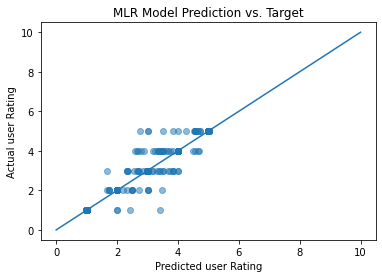

In [126]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('MLR Model Prediction vs. Target')
plt.xlabel('Predicted user Rating')
plt.ylabel('Actual user Rating');

In [128]:
meanSquaredError1 = mean_squared_error(y_test, test_set_pred)
print("MSE:", meanSquaredError1)

MSE: 0.2080935115192944


In [127]:
print('MLR R-squared: {:.4f}'.format(r2_score(y_test, test_set_pred))) 

MLR R-squared: 0.8558


# Ridge model

In [129]:
users_df = df_in['user']
user_keywords_df = pd.concat([users_df, keywords_df], axis=1)

In [130]:
X, y = user_keywords_df.iloc[:,2:], df_in['rating']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [131]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=20)

In [132]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y) # --> Necessary for next block of code
lr = LinearRegression()

In [133]:
# Here we'll validate our Linear model vs. the Ridge model
kf = KFold(n_splits=5, shuffle=True, random_state = 61)
cv_lr_r2s, cv_lr_reg_r2s = [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #Linear Regression
    lr = LinearRegression()
    lr_reg = Ridge(alpha=1)

    lr.fit(X_train, y_train)
    cv_lr_r2s.append(lr.score(X_val, y_val))
    
    #Ridge
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lr_reg.fit(X_train_scaled, y_train)
    cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))

print('Ridge scores: ', cv_lr_reg_r2s, '\n')
print(f'Ridge mean cv R-squared: {np.mean(cv_lr_reg_r2s):.3f} +- {np.std(cv_lr_reg_r2s):.3f}')

Ridge scores:  [0.6291124560634986, 0.5664775912609792, 0.5248714992942627, 0.5487266297425502, 0.47222407255855425] 

Ridge mean cv R-squared: 0.548 +- 0.051


In [134]:
# Resetting the data
X, y = user_keywords_df.iloc[:,2:], df_in['rating']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [135]:
# Rescale the data for  Ridge testing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [136]:
lr_reg.fit(X_train_scaled, y_train);

In [137]:
test_set_pred = lr_reg.predict(X_test_scaled)

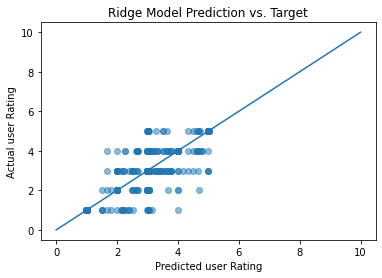

In [138]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Ridge Model Prediction vs. Target')
plt.xlabel('Predicted user Rating')
plt.ylabel('Actual user Rating');

In [139]:
print('Ridge R-squared: {:.4f}'.format(r2_score(y_test, test_set_pred))) 

Ridge R-squared: 0.5239


In [140]:
meanSquaredError2 = mean_squared_error(y_test, test_set_pred)
print("MSE:", meanSquaredError2)

MSE: 0.6462560795610564
